In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import mutual_info_classif
import time
from scipy.stats import chi2
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Datasets

In [2]:
def dataset_1(random_state=42):
    X, y = make_classification(
        n_samples=10000,
        n_features=10,
        n_informative=5,
        n_redundant=2,
        n_classes=2,
        random_state=random_state
    )

    discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
    X = discretizer.fit_transform(X)
    return X, y

In [3]:
def dataset_2(random_state=42):
    np.random.seed(random_state)
    X = np.random.randint(0, 2, (1000, 100))
    y = ((X[:, 0] ^ X[:, 1]) | (X[:, 2] & X[:, 3] & X[:, 4])).astype(int)
    return X, y

In [4]:
def dataset_3(random_state=42):
    n = 1000
    p = 14
    k = 6

    np.random.seed(random_state)
    X = np.random.randn(n, p)
    chisq_median = chi2.median(k)
    y = ((X[:, :k]**2).sum(axis=1) > chisq_median).astype(int)

    return X, y

# Filters

In [5]:
def gini(X, y):
    data = []
    for col in range(X.shape[1]):
        temp_df = pd.DataFrame({'X': X[:, col], 'y': y})
        x_y_count = temp_df.groupby(['X', 'y'])['y'].count()
        x_count = temp_df.groupby('X').count()['y']
        gini_vals = 1 - ((x_y_count / x_count)**2).groupby('X').sum()
        gini_val = (x_count * gini_vals / X.shape[0]).sum()
        data.append({'feature': col, 'gini': gini_val})
    return pd.DataFrame(data)

def gini_method(X, y, top_k=5):
    chosen_features = gini(X, y).sort_values('gini')['feature'].to_numpy()[:top_k]
    return chosen_features

In [6]:
def mutual_info(X, y):
    mi = mutual_info_classif(X, y, discrete_features='auto')
    return pd.DataFrame({
        'feature': np.arange(X.shape[1]),
        'mutual_info': mi
    })

def mutual_info_method(X, y, top_k=5):
    mi_df = mutual_info(X, y).sort_values('mutual_info', ascending=False)
    return mi_df['feature'].to_numpy()[:top_k]


# Wrapper

In [7]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

def rfe(X, y):
    estimator = SVR(kernel='linear')
    rfe = RFE(estimator, n_features_to_select=5, step=1)
    rfe.fit(X, y)
    result = rfe.ranking_
    result = np.where(result == 1)[0]
    return list(result.reshape((-1,)))

# Feature Selection Evaluation

In [8]:
def eval_feature_selection(dataset_method, feature_method, relevant_features, tests=5):
    scores = []
    for i in tqdm(range(tests)):
        X, y = dataset_method(random_state=i)
        chosen_features = feature_method(X, y)
        Rs = len(set(chosen_features).intersection(set(relevant_features)))
        Rt = len(relevant_features)
        Is = len(chosen_features) - Rs
        It = X.shape[1] - len(relevant_features)
        alpha = min(0.5, Rt / It)
        score = (Rs / Rt - alpha * Is / It) * 100
        scores.append(score)
    print(scores)

In [9]:
def compare_feature_selection_methods(tests=5):
    datasets = {
        'Dataset 1': {
            'method': dataset_1,
            'relevant_features': [0, 1, 2, 3, 4]
        },
        'Dataset 2': {
            'method': dataset_2,
            'relevant_features': [0, 1, 2, 3, 4]
        },
        'Dataset 3': {
            'method': dataset_3,
            'relevant_features': list(range(6))
        }
    }
    
    methods = {
        'Gini': gini_method,
        'Mutual Info': mutual_info_method,
        'RFE': rfe
    }
    
    results = []
    
    for dataset_name, dataset_info in datasets.items():
        for method_name, method_func in methods.items():
            print(f"Testing {method_name} on {dataset_name}...")
            scores = []
            for i in tqdm(range(tests)):
                X, y = dataset_info['method'](random_state=i)
                chosen_features = method_func(X, y)
                relevant_features = dataset_info['relevant_features']
                
                Rs = len(set(chosen_features).intersection(set(relevant_features)))
                Rt = len(relevant_features)
                Is = len(chosen_features) - Rs
                It = X.shape[1] - len(relevant_features)
                alpha = min(0.5, Rt / It)
                score = (Rs / Rt - alpha * Is / It) * 100
                
                scores.append(score)
            
            for score in scores:
                results.append({
                    'Dataset': dataset_name,
                    'Method': method_name,
                    'Score': score
                })
    
    results_df = pd.DataFrame(results)
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(
        data=results_df,
        x='Dataset',
        y='Score',
        hue='Method',
        palette='Set2'
    )
    plt.title('Feature Selection Method Performance Comparison', fontsize=16, pad=20)
    plt.xlabel('Dataset', fontsize=12)
    plt.ylabel('Selection Score', fontsize=12)
    plt.ylim(-20, 120)
    plt.legend(title='Feature Selection Method', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

Testing Gini on Dataset 1...


100%|██████████| 3/3 [00:00<00:00, 19.12it/s]


Testing Mutual Info on Dataset 1...


100%|██████████| 3/3 [00:00<00:00,  3.02it/s]


Testing RFE on Dataset 1...


100%|██████████| 3/3 [02:42<00:00, 54.33s/it]


Testing Gini on Dataset 2...


100%|██████████| 3/3 [00:00<00:00,  4.68it/s]


Testing Mutual Info on Dataset 2...


100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


Testing RFE on Dataset 2...


100%|██████████| 3/3 [01:47<00:00, 35.71s/it]


Testing Gini on Dataset 3...


100%|██████████| 3/3 [00:00<00:00, 18.54it/s]


Testing Mutual Info on Dataset 3...


100%|██████████| 3/3 [00:00<00:00, 12.78it/s]


Testing RFE on Dataset 3...


100%|██████████| 3/3 [00:04<00:00,  1.34s/it]


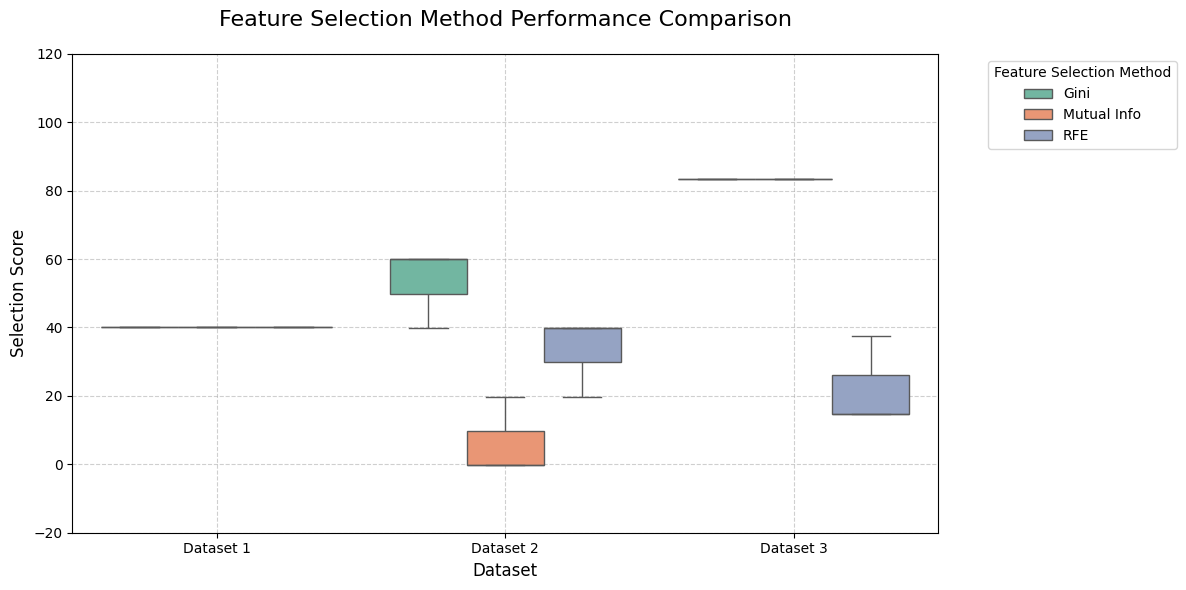

In [71]:
compare_feature_selection_methods(3)

## Evaluate Models

In [10]:
def get_metric_data(model, x_train, x_test, y_train, y_test):
    model.fit(x_train, y_train)
    y_test_pred = model.predict(x_test)

    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    return ({
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

accuracy, precision, recall and F1 score

In [14]:
def eval_model(model, X, y, feature_mask, relevant_mask):
    def get_metric_data(model, x_train, x_test, y_train, y_test):
        model.fit(x_train, y_train)
        y_test_pred = model.predict(x_test)

        accuracy = accuracy_score(y_test, y_test_pred)
        precision = precision_score(y_test, y_test_pred)
        recall = recall_score(y_test, y_test_pred)
        f1 = f1_score(y_test, y_test_pred)
        return ({
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        })
    
    kf = KFold(n_splits=50)
    data_full = []
    data_chosen = []
    data_relevant = []
    for i, (train_index, test_index) in tqdm(enumerate(kf.split(X))):
        x_train, x_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
        data_full.append(get_metric_data(model, x_train, x_test, y_train, y_test))
        data_chosen.append(get_metric_data(model, x_train[:, feature_mask], x_test[:, feature_mask], y_train, y_test))
        data_relevant.append(get_metric_data(model, x_train[:, relevant_mask], x_test[:, relevant_mask], y_train, y_test))
    data_full = pd.DataFrame(data_full)
    data_chosen = pd.DataFrame(data_chosen)
    data_relevant = pd.DataFrame(data_relevant)

    fig, axs = plt.subplots(3, 4, figsize=(16, 12))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)

    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    datasets = [
        (data_full, 'Full Feature Set', 'firebrick'),
        (data_chosen, 'Chosen Feature Set', 'gold'),
        (data_relevant, 'Relevant Feature Set', 'seagreen')
    ]

    x_limits = {}
    for col_idx, metric in enumerate(metrics):
        min_val = min(data_full[metric].min(), 
                    data_chosen[metric].min(), 
                    data_relevant[metric].min())
        max_val = max(data_full[metric].max(),
                    data_chosen[metric].max(),
                    data_relevant[metric].max())
        x_limits[col_idx] = (min_val - 0.02, max_val + 0.02)

    for row_idx, (data, label, color) in enumerate(datasets):
        for col_idx, metric in enumerate(metrics):
            sns.histplot(
                data=data,
                x=metric,
                ax=axs[row_idx, col_idx],
                color=color,
                kde=True,
                bins=15,
                alpha=0.4
            )
            
            axs[row_idx, col_idx].set_xlim(x_limits[col_idx])
            
            axs[row_idx, col_idx].grid(True, linestyle='--', alpha=0.6)
            
            if col_idx == 0:
                axs[row_idx, col_idx].set_ylabel(label, fontsize=12, fontweight='bold')
                
            if row_idx == 0:
                axs[row_idx, col_idx].set_title(metric, fontsize=14, fontweight='bold')

    for col_idx, metric in enumerate(metrics):
        axs[2, col_idx].set_xlabel(f'{metric} Value', fontsize=10)

    plt.suptitle('Performance Metrics Distribution Comparison', y=1.02, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [12]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## Random Forest

50it [01:16,  1.53s/it]


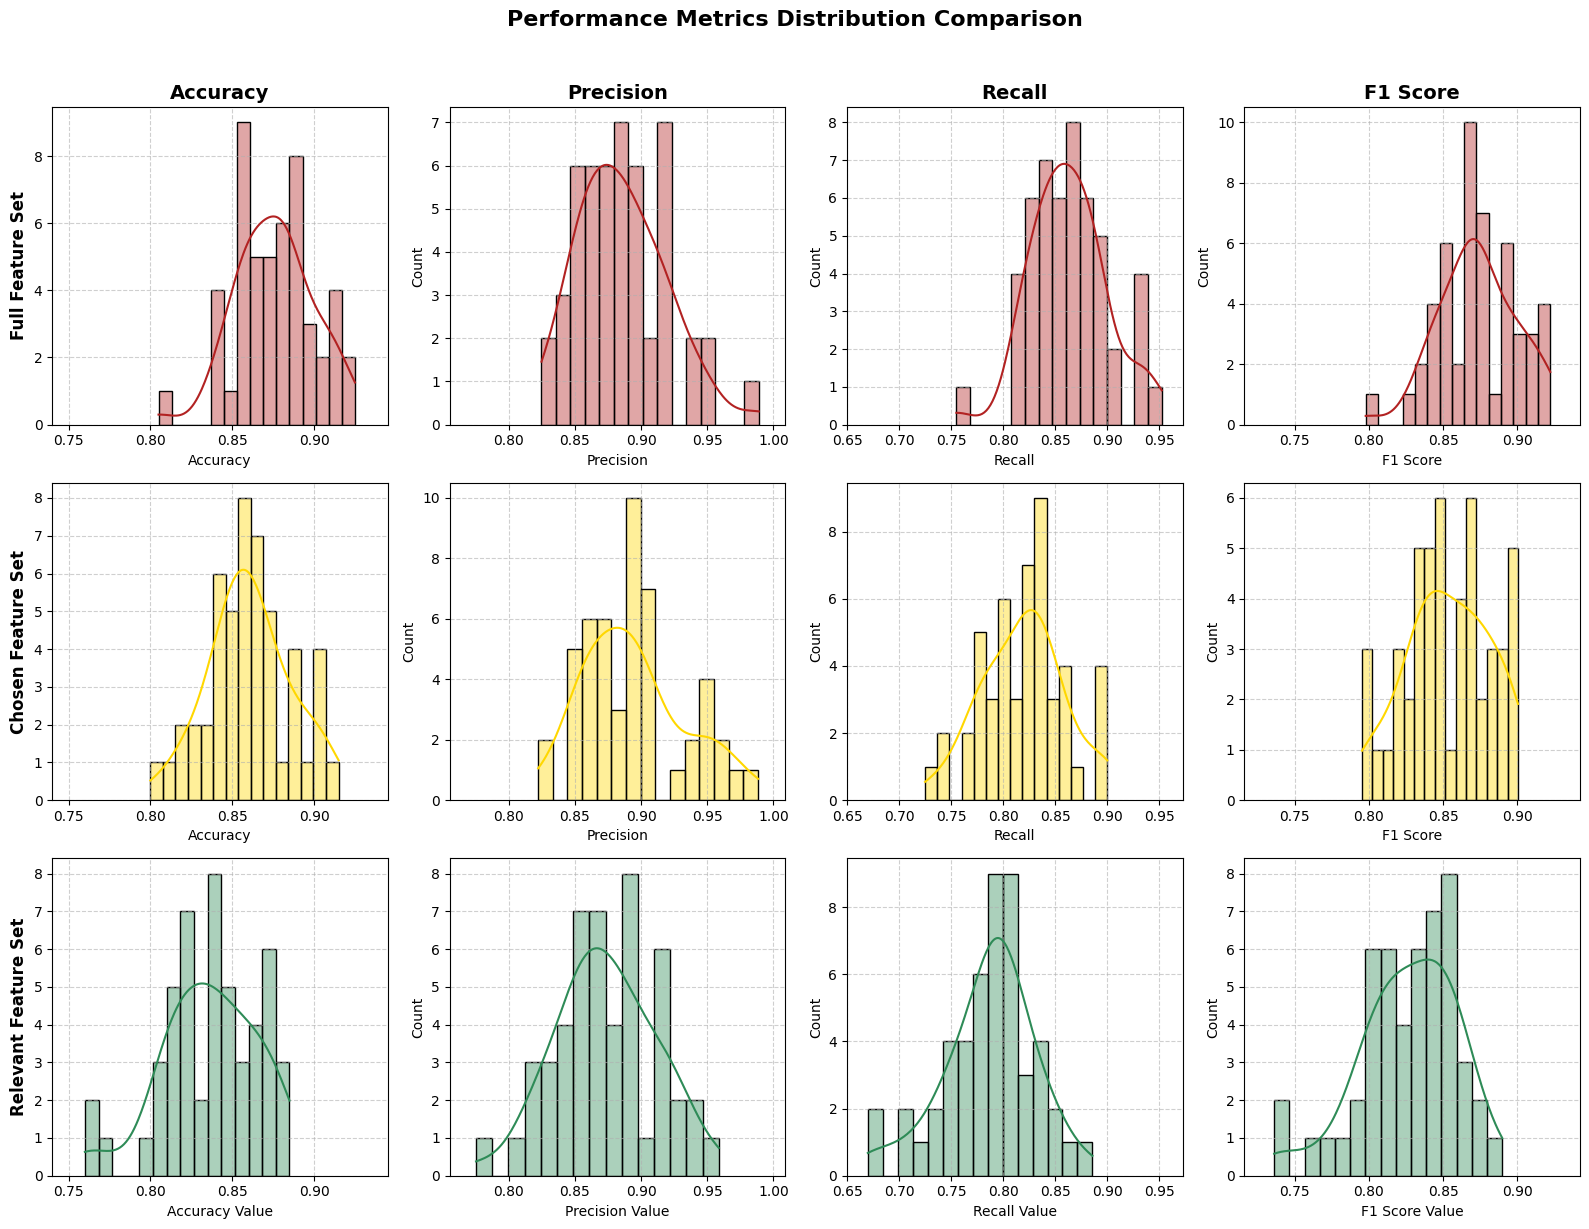

50it [01:13,  1.47s/it]


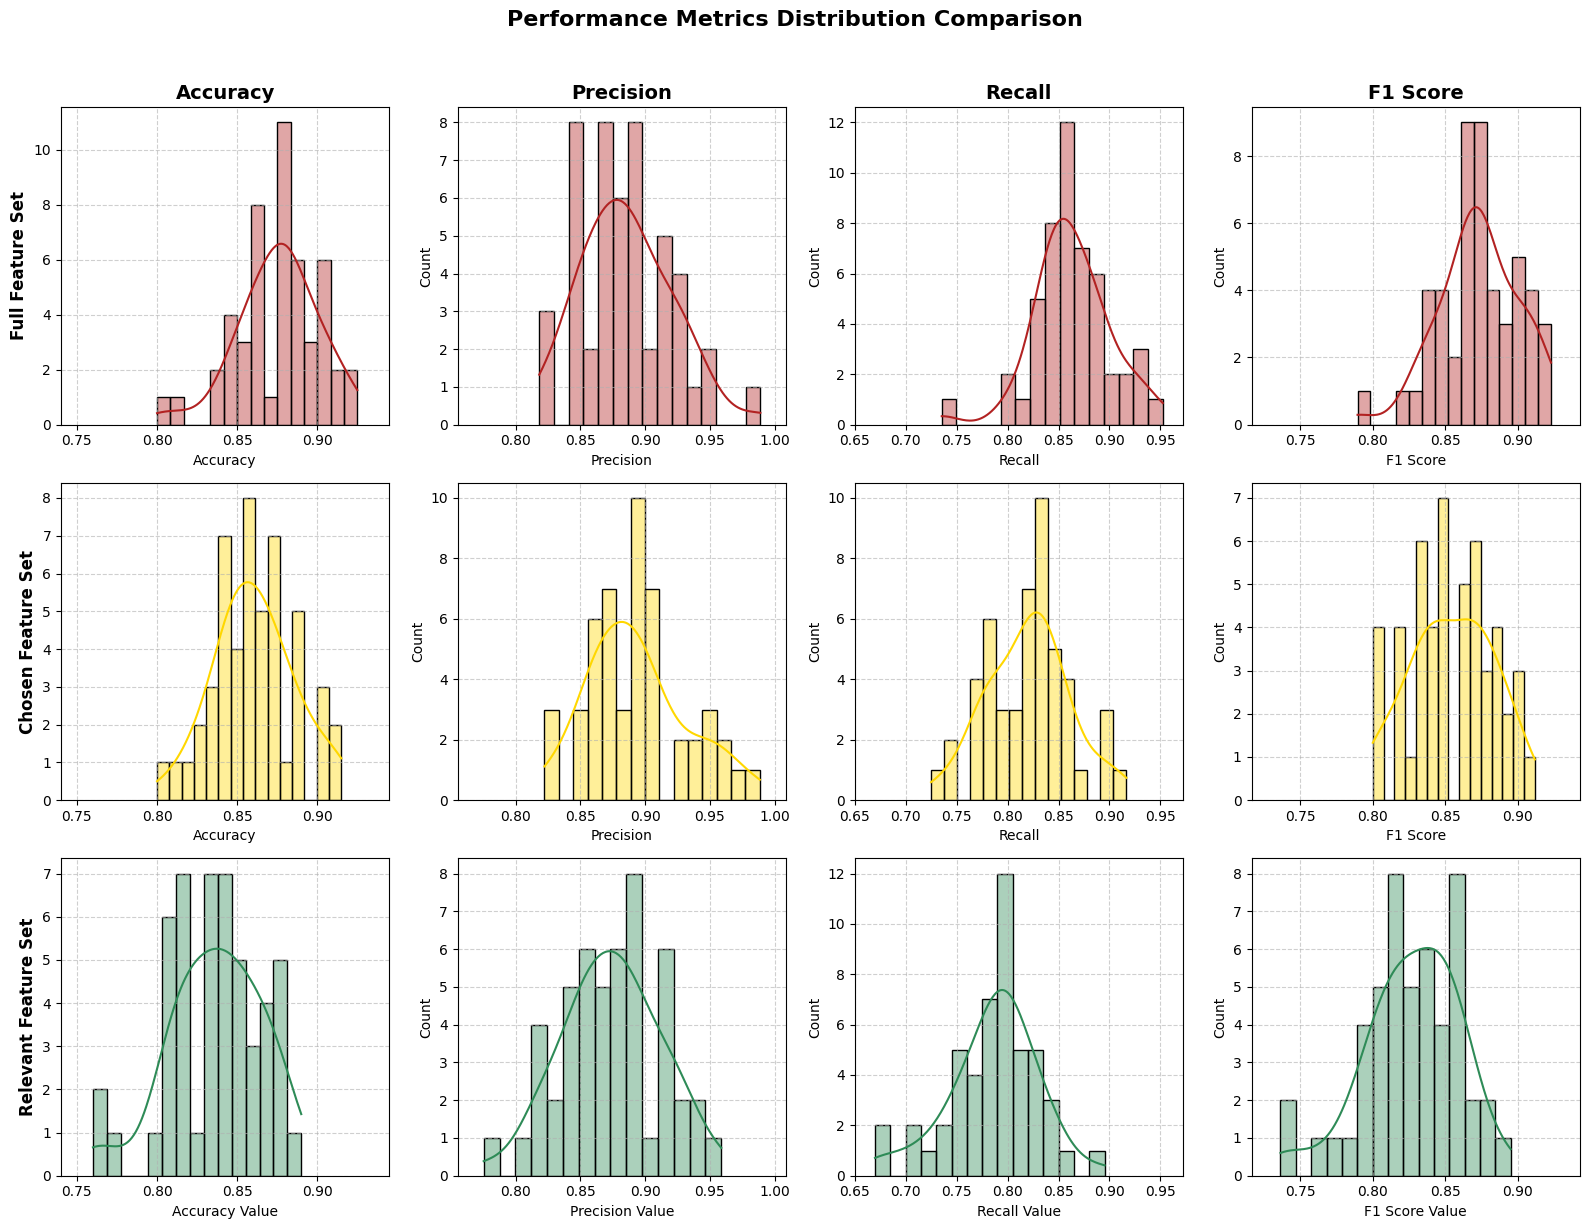

50it [01:25,  1.70s/it]


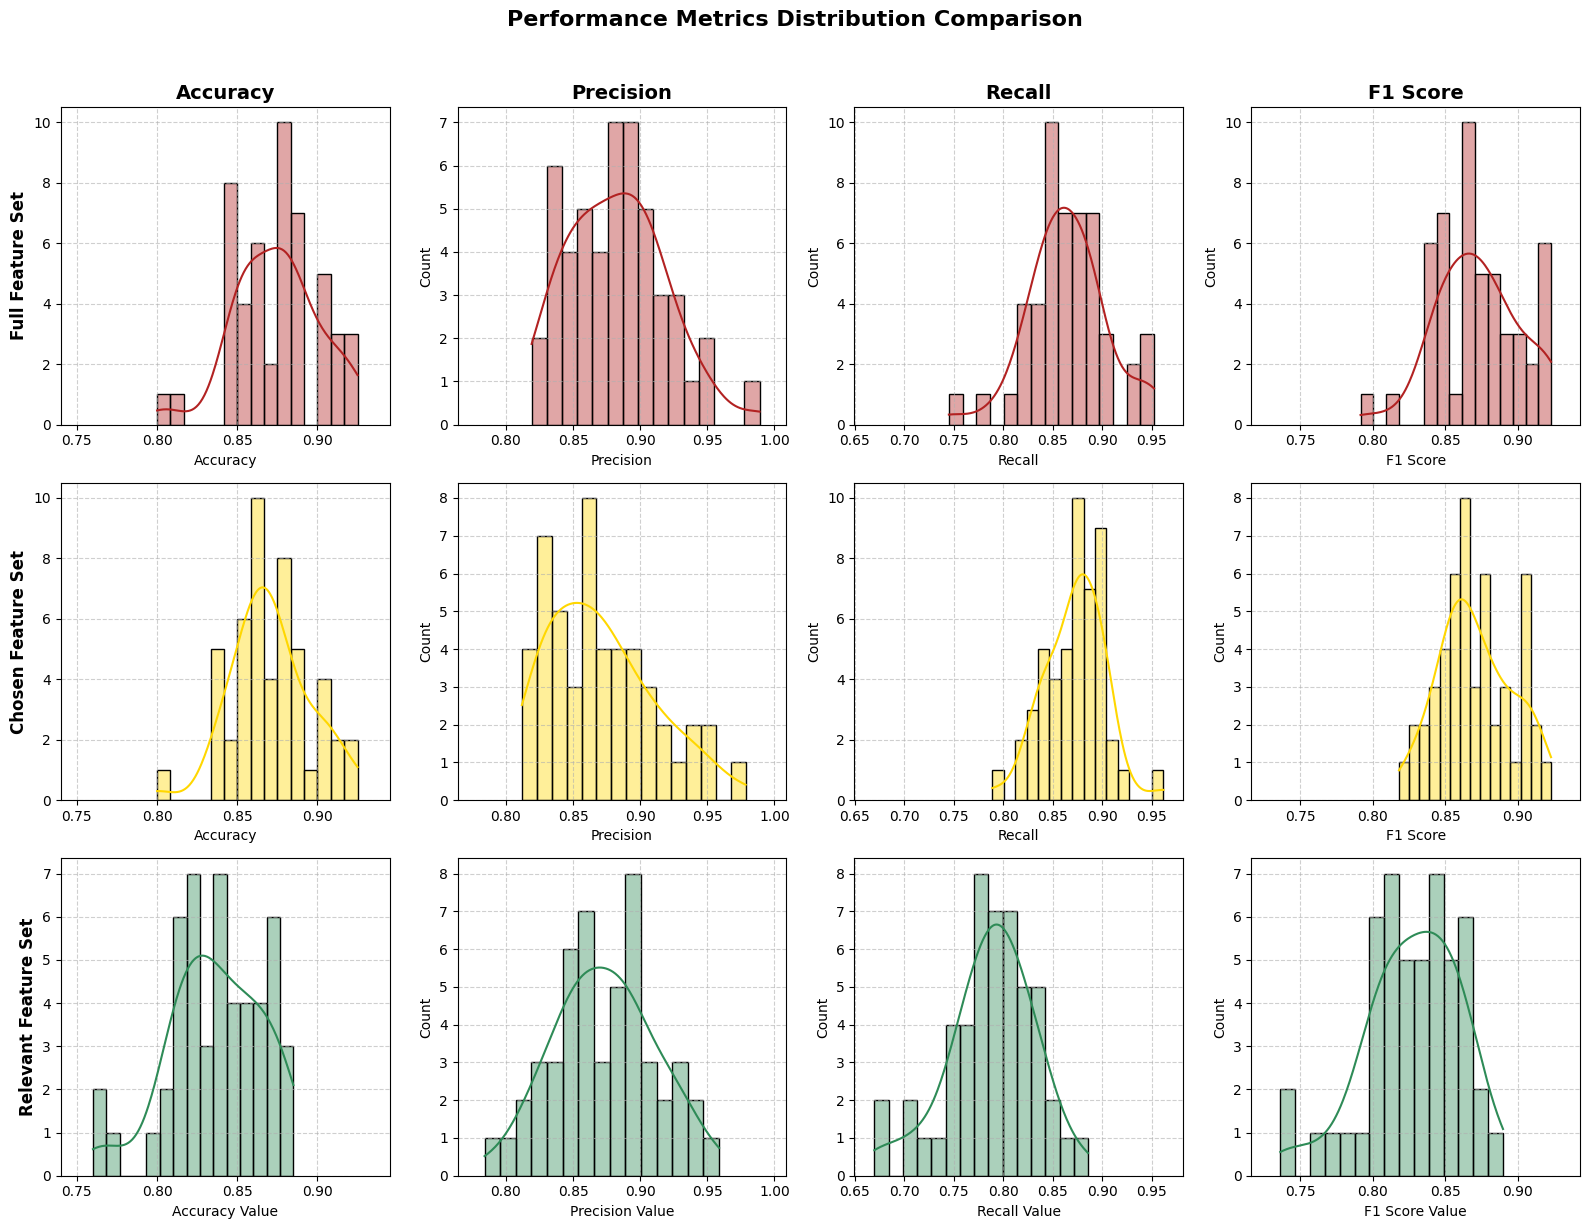

In [20]:
model = RandomForestClassifier()
X, y = dataset_1()
feature_mask = gini_method(X, y, 5)
relevant_mask = [0, 1, 2, 3, 4]
eval_model(model, X, y, feature_mask, relevant_mask)

model = RandomForestClassifier()
X, y = dataset_1()
feature_mask = mutual_info_method(X, y, 5)
relevant_mask = [0, 1, 2, 3, 4]
eval_model(model, X, y, feature_mask, relevant_mask)

model = RandomForestClassifier()
X, y = dataset_1()
feature_mask = rfe(X, y)
relevant_mask = [0, 1, 2, 3, 4]
eval_model(model, X, y, feature_mask, relevant_mask)

50it [00:32,  1.52it/s]


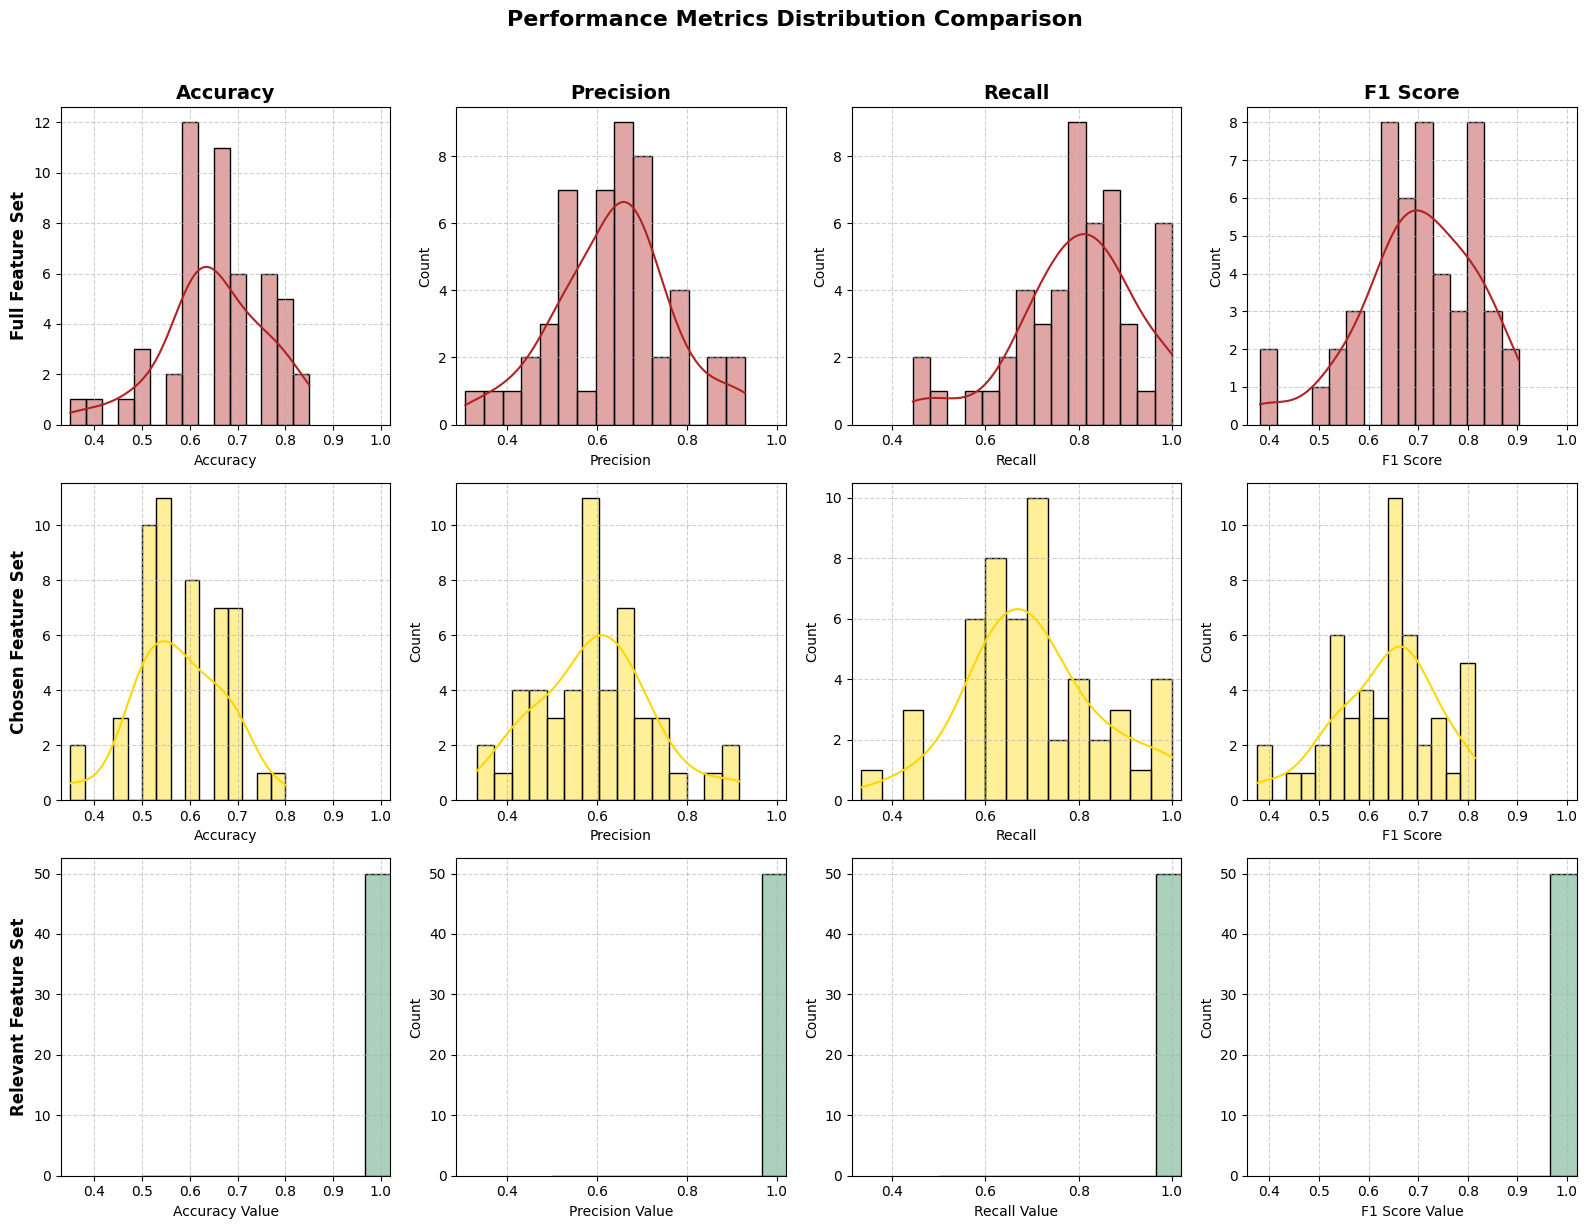

50it [00:26,  1.87it/s]


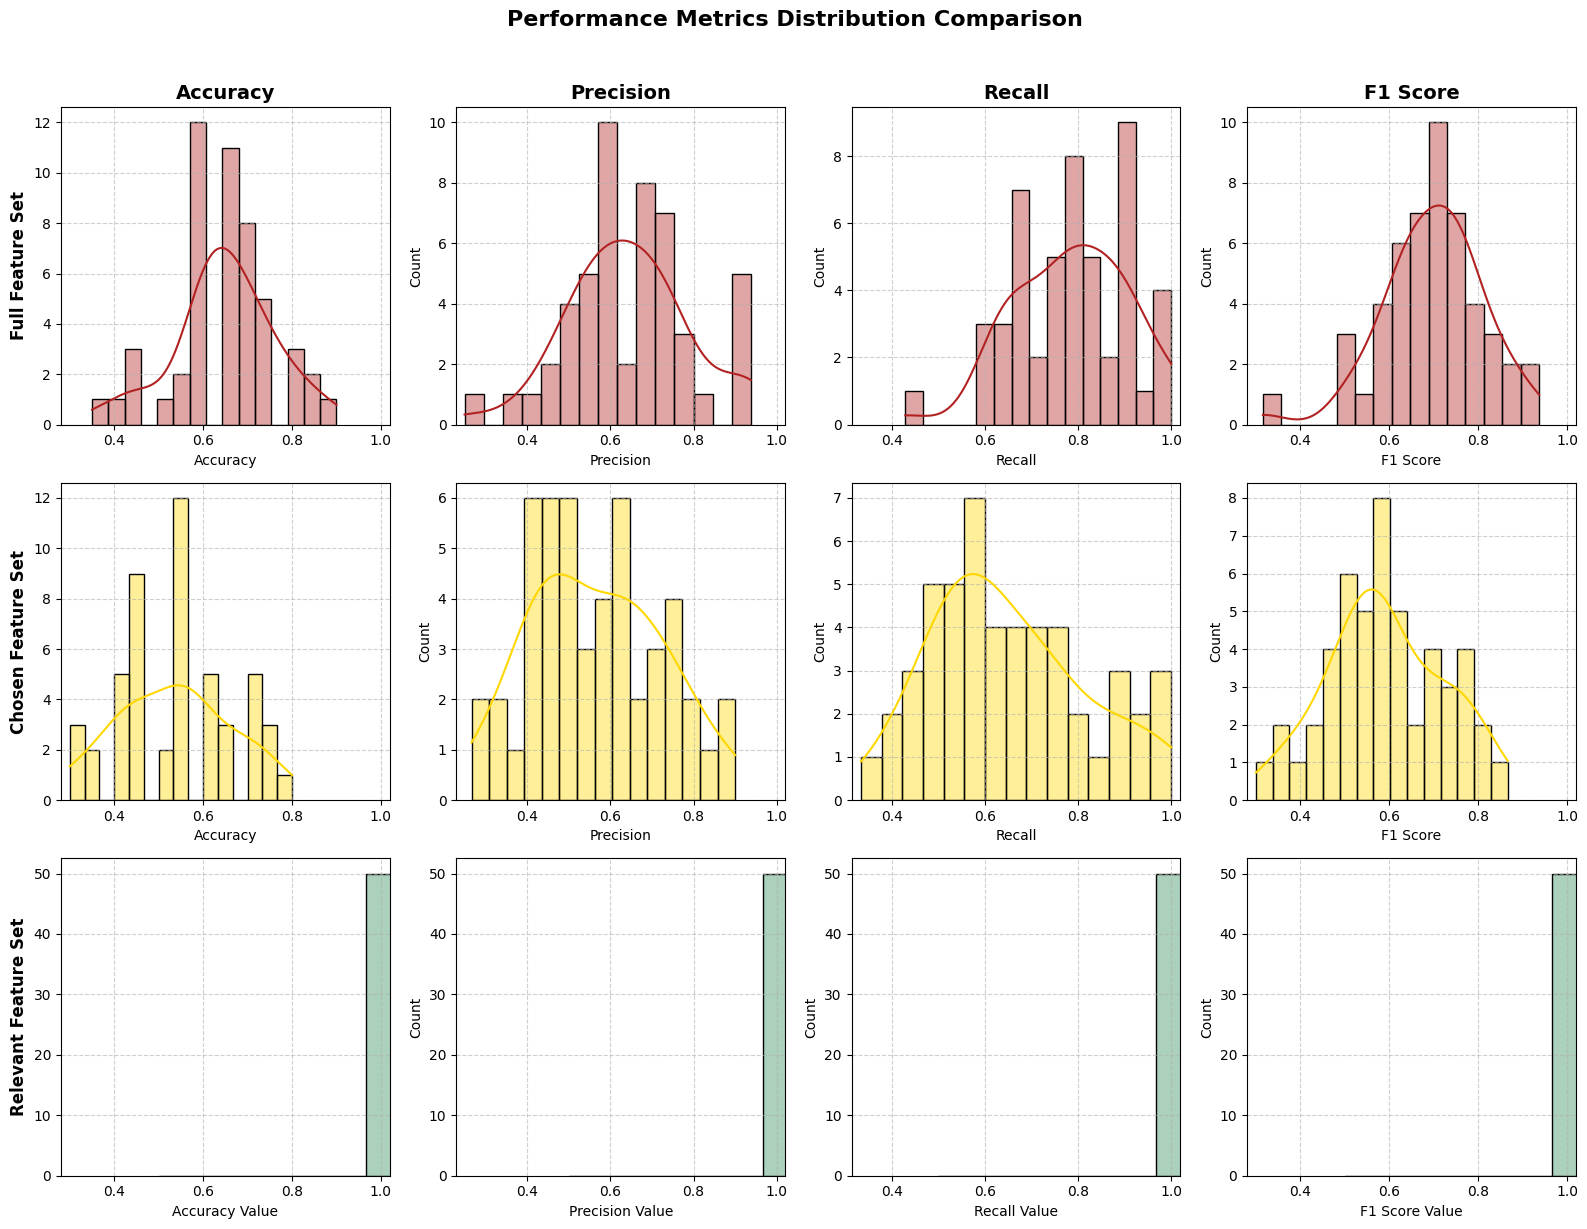

50it [00:32,  1.54it/s]


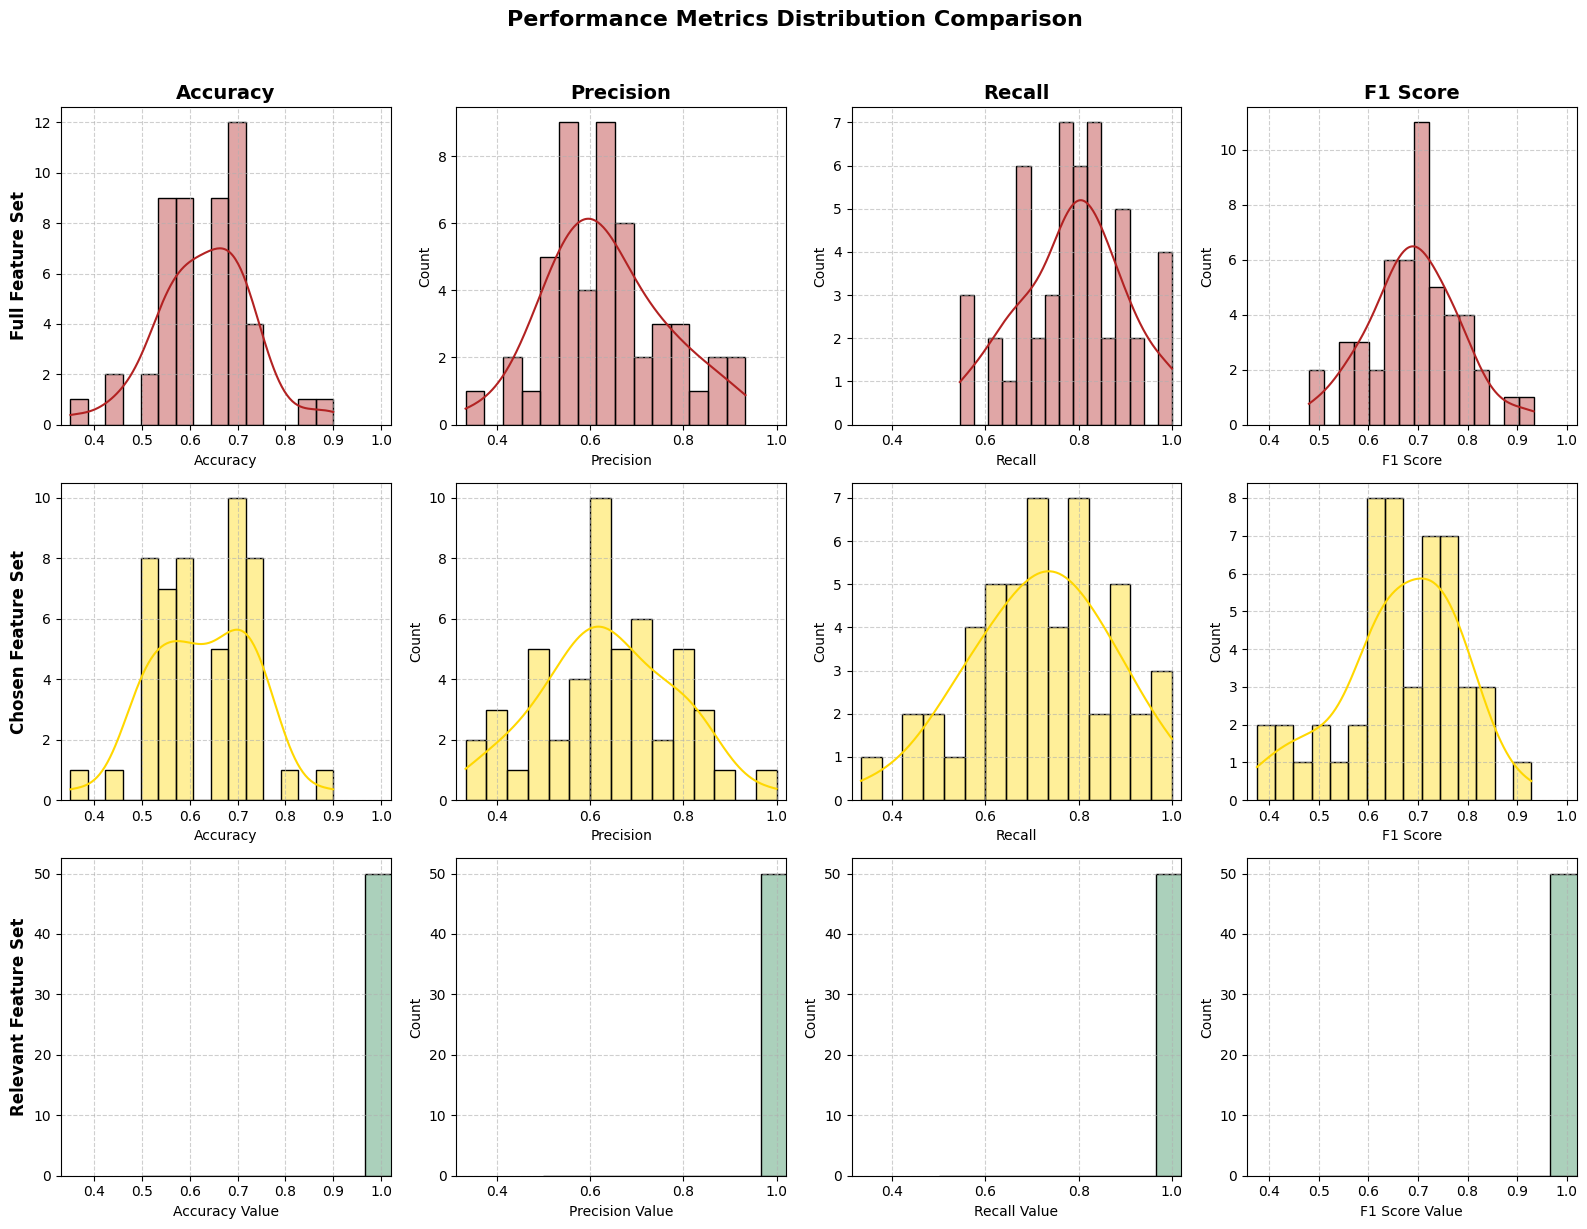

In [21]:
model = RandomForestClassifier()
X, y = dataset_2()
feature_mask = gini_method(X, y, 5)
relevant_mask = [0, 1, 2, 3, 4]
eval_model(model, X, y, feature_mask, relevant_mask)

model = RandomForestClassifier()
X, y = dataset_2()
feature_mask = mutual_info_method(X, y, 5)
relevant_mask = [0, 1, 2, 3, 4]
eval_model(model, X, y, feature_mask, relevant_mask)

model = RandomForestClassifier()
X, y = dataset_2()
feature_mask = rfe(X, y)
relevant_mask = [0, 1, 2, 3, 4]
eval_model(model, X, y, feature_mask, relevant_mask)

50it [00:54,  1.08s/it]


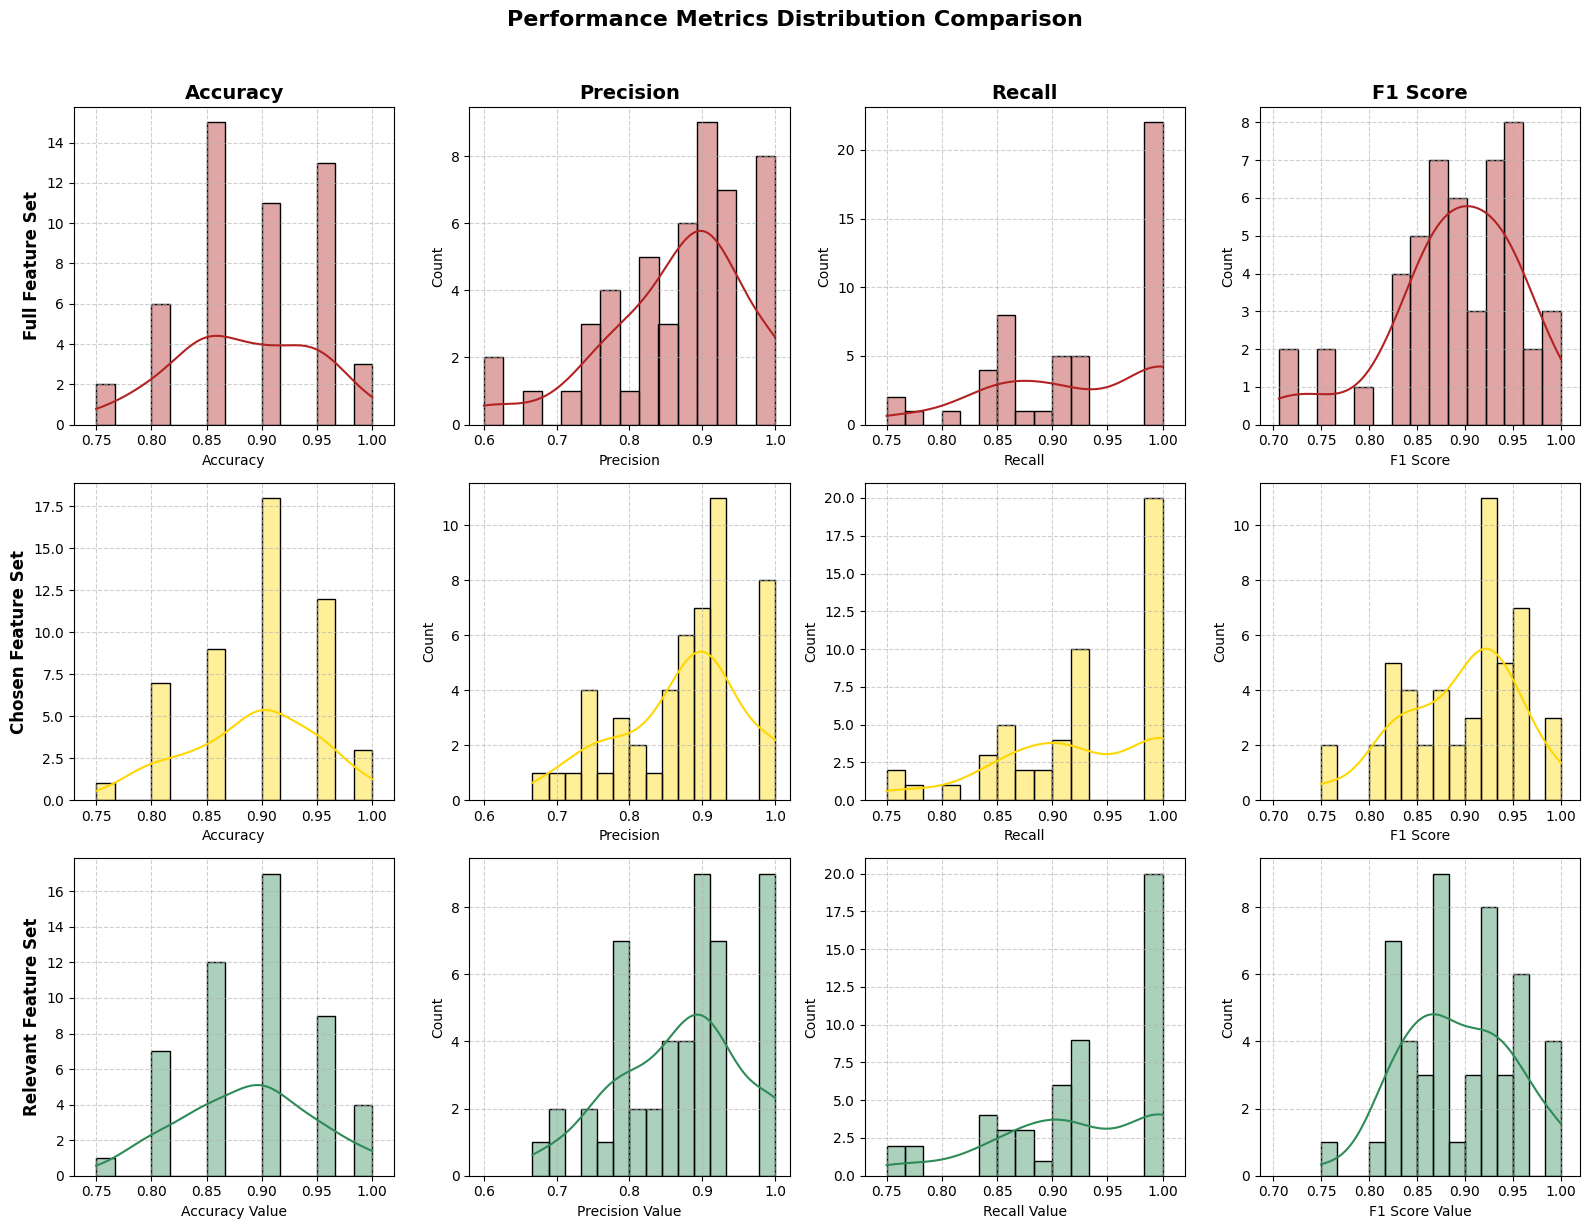

50it [01:16,  1.53s/it]


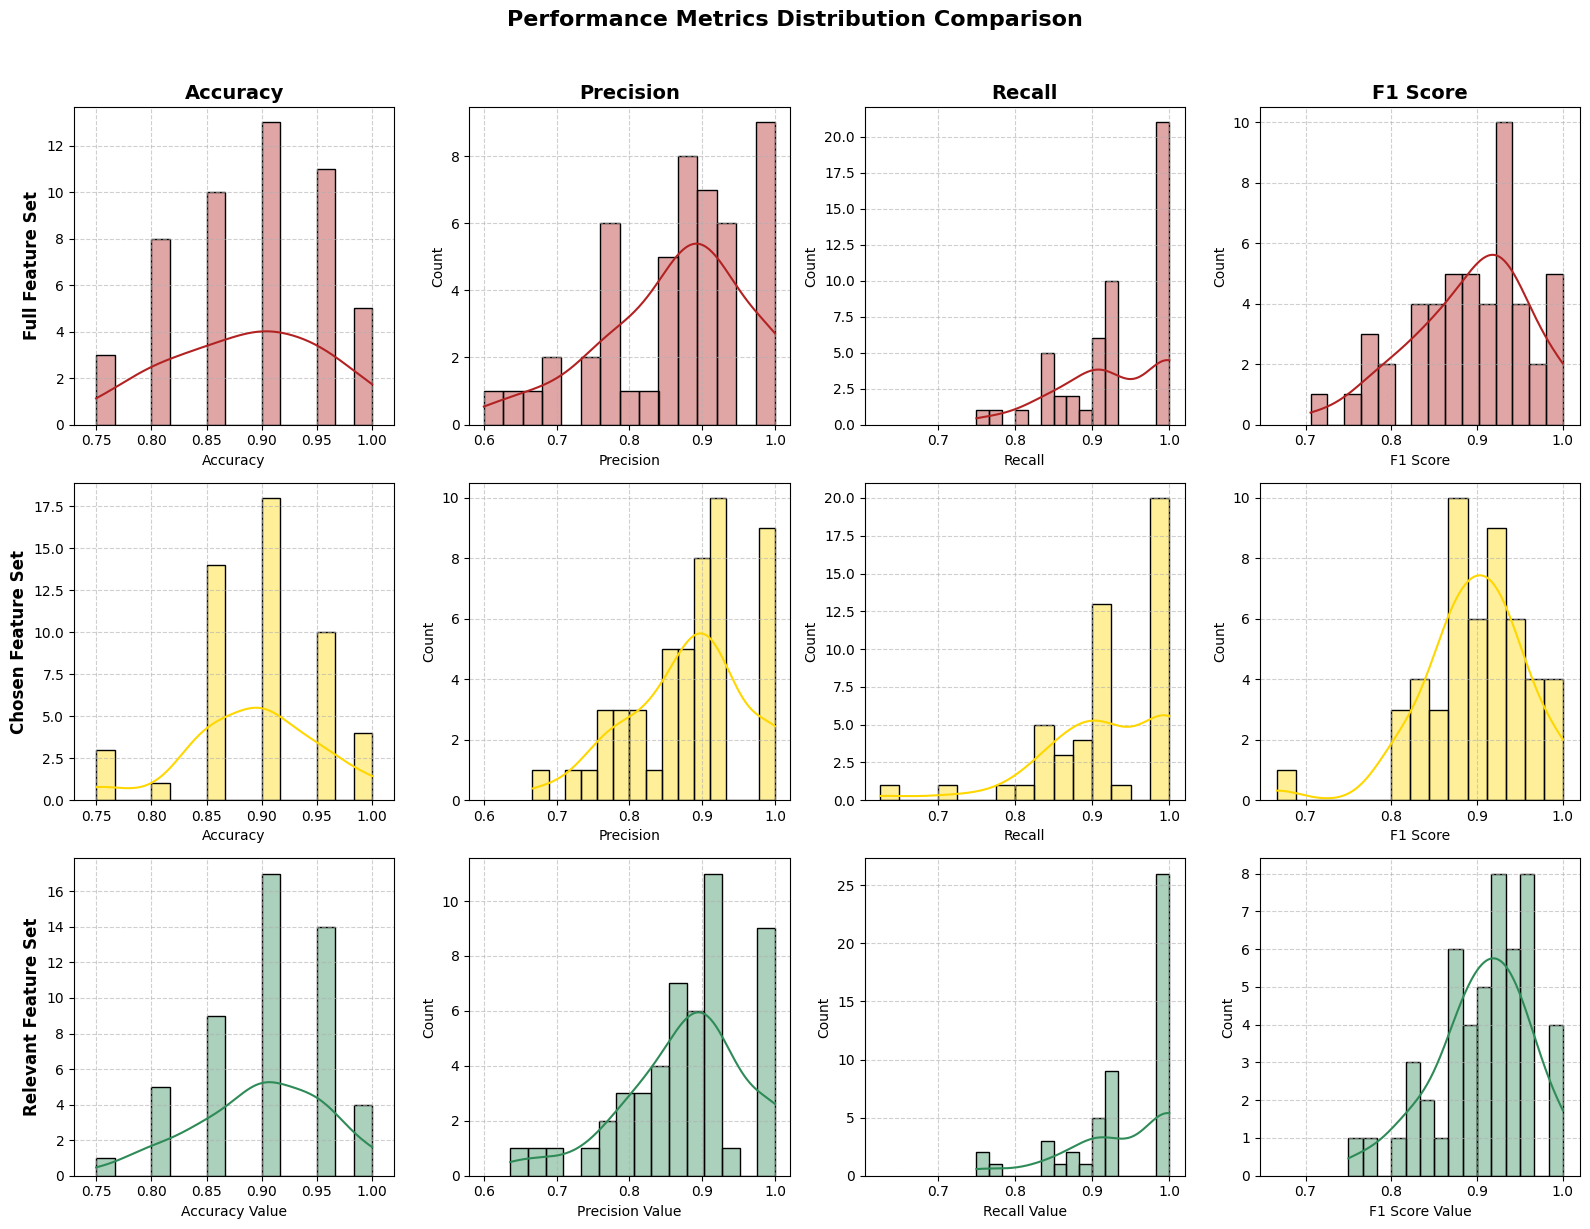

50it [01:02,  1.26s/it]


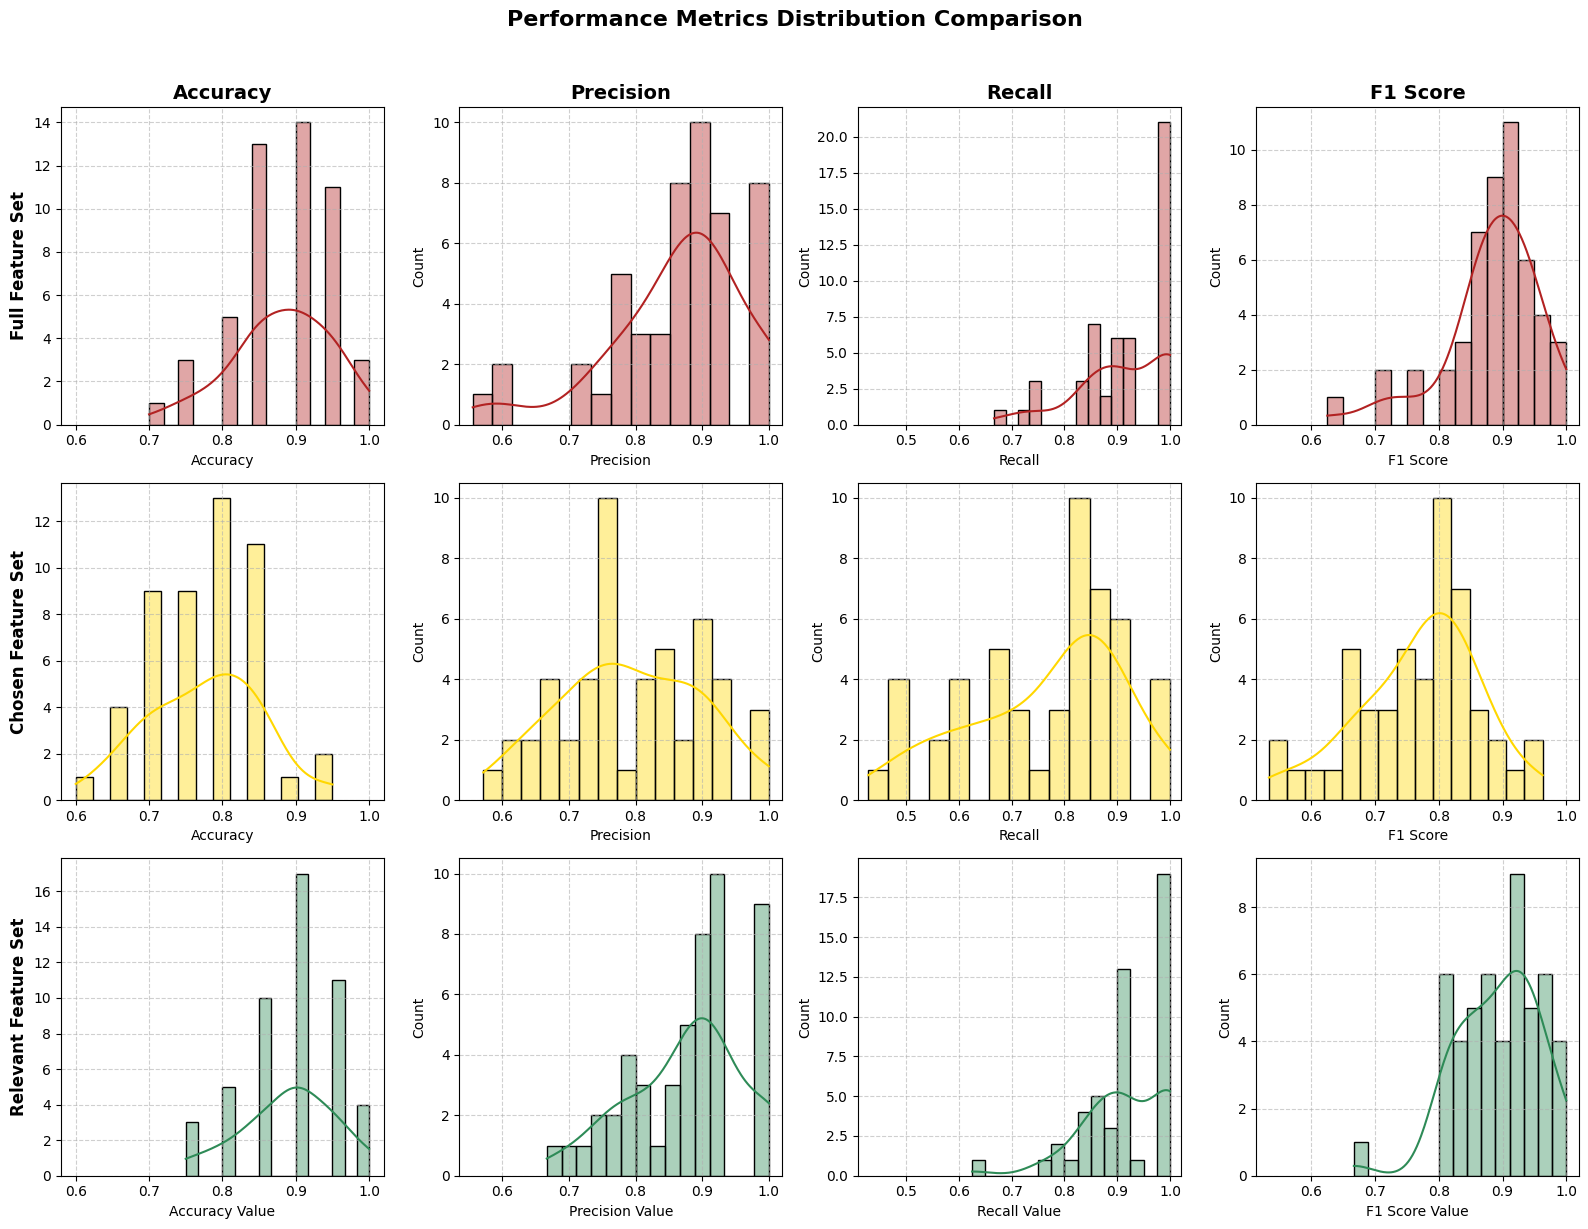

In [26]:
model = RandomForestClassifier()
X, y = dataset_3()
feature_mask = gini_method(X, y, 6)
relevant_mask = [0, 1, 2, 3, 4, 5]
eval_model(model, X, y, feature_mask, relevant_mask)

model = RandomForestClassifier()
X, y = dataset_3()
feature_mask = mutual_info_method(X, y, 6)
relevant_mask = [0, 1, 2, 3, 4, 5]
eval_model(model, X, y, feature_mask, relevant_mask)

model = RandomForestClassifier()
X, y = dataset_3()
feature_mask = rfe(X, y)
relevant_mask = [0, 1, 2, 3, 4, 5]
eval_model(model, X, y, feature_mask, relevant_mask)

## SVM

## Metrics Boxplots

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import numpy as np

def evaluate_feature_selection_performance(tests=5):
    """Compare feature selection methods using the Swc score across multiple datasets."""
    datasets = {
        'Dataset 1': {
            'generator': dataset_1,
            'relevant_features': [0, 1, 2, 3, 4]
        },
        'Dataset 2': {
            'generator': dataset_2,
            'relevant_features': [0, 1, 2, 3, 4]
        },
        'Dataset 3': {
            'generator': dataset_3,
            'relevant_features': list(range(6))
        }
    }
    
    feature_selectors = {
        'Gini': gini_method,
        'Mutual Info': mutual_info_method,
        'RFE': rfe
    }
    
    results = []
    
    for dataset_name, dataset_info in datasets.items():
        for method_name, selector_func in feature_selectors.items():
            print(f"Evaluating {method_name} on {dataset_name}...")
            scores = []
            for i in tqdm(range(tests)):
                X, y = dataset_info['generator'](random_state=i)
                selected_features = selector_func(X, y)
                relevant_features = dataset_info['relevant_features']
                
                # Calculate Swc score
                Rs = len(set(selected_features).intersection(set(relevant_features)))
                Rt = len(relevant_features)
                Is = len(selected_features) - Rs
                It = X.shape[1] - len(relevant_features)
                alpha = min(0.5, Rt / It)
                score = (Rs / Rt - alpha * Is / It) * 100
                
                scores.append(score)
            
            for score in scores:
                results.append({
                    'Dataset': dataset_name,
                    'Method': method_name,
                    'Swc Score': score
                })
    
    results_df = pd.DataFrame(results)
    plot_feature_selection_comparison(results_df)
    return results_df

def plot_feature_selection_comparison(results_df):
    """Visualize feature selection performance using boxplots."""
    plt.figure(figsize=(12, 6))
    sns.boxplot(
        data=results_df,
        x='Dataset',
        y='Swc Score',
        hue='Method',
        palette='Set2'
    )
    plt.title('Feature Selection Method Performance Comparison', fontsize=16)
    plt.xlabel('Dataset', fontsize=12)
    plt.ylabel('Swc Score', fontsize=12)
    plt.ylim(-20, 120)
    plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

def evaluate_model_performance(model, datasets, feature_selectors, n_splits=50):
    """Evaluate classifier performance across datasets and feature selection methods."""
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    results = []
    
    for dataset_name, dataset_info in datasets.items():
        X, y = dataset_info['generator'](random_state=42)
        relevant_mask = np.zeros(X.shape[1], dtype=bool)
        relevant_mask[dataset_info['relevant_features']] = True
        
        for method_name, selector_func in feature_selectors.items():
            print(f"Testing {method_name} on {dataset_name}...")
            selected_mask = np.zeros(X.shape[1], dtype=bool)
            selected_features = selector_func(X, y)
            selected_mask[selected_features] = True
            
            kf = KFold(n_splits=n_splits)
            for train_index, test_index in tqdm(kf.split(X), total=n_splits):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                
                # Evaluate on selected features
                X_train_selected = X_train[:, selected_mask]
                X_test_selected = X_test[:, selected_mask]
                model.fit(X_train_selected, y_train)
                y_pred = model.predict(X_test_selected)
                
                results.append({
                    'Dataset': dataset_name,
                    'Method': method_name,
                    'Accuracy': accuracy_score(y_test, y_pred),
                    'Precision': precision_score(y_test, y_pred),
                    'Recall': recall_score(y_test, y_pred),
                    'F1 Score': f1_score(y_test, y_pred)
                })
    
    results_df = pd.DataFrame(results)
    plot_performance_histograms(results_df)
    return results_df

def plot_performance_histograms(results_df):
    """Plot histograms of performance metrics across methods and datasets."""
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    
    for metric in metrics:
        plt.figure(figsize=(15, 10))
        g = sns.FacetGrid(
            data=results_df,
            col='Dataset',
            row='Method',
            hue='Method',
            palette='Set2',
            height=3,
            aspect=1.2
        )
        g.map(sns.histplot, metric, kde=True, bins=15, alpha=0.6)
        g.add_legend()
        
        plt.suptitle(f'Distribution of {metric} by Method and Dataset', y=1.02, fontsize=16)
        plt.tight_layout()
        plt.show()

Evaluating Gini on Dataset 1...


100%|██████████| 5/5 [00:00<00:00, 16.24it/s]


Evaluating Mutual Info on Dataset 1...


100%|██████████| 5/5 [00:01<00:00,  2.79it/s]


Evaluating RFE on Dataset 1...


100%|██████████| 5/5 [08:18<00:00, 99.76s/it] 


Evaluating Gini on Dataset 2...


100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Evaluating Mutual Info on Dataset 2...


100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


Evaluating RFE on Dataset 2...


100%|██████████| 5/5 [04:58<00:00, 59.74s/it]


Evaluating Gini on Dataset 3...


100%|██████████| 5/5 [00:00<00:00,  8.96it/s]


Evaluating Mutual Info on Dataset 3...


100%|██████████| 5/5 [00:00<00:00,  6.13it/s]


Evaluating RFE on Dataset 3...


100%|██████████| 5/5 [00:11<00:00,  2.30s/it]


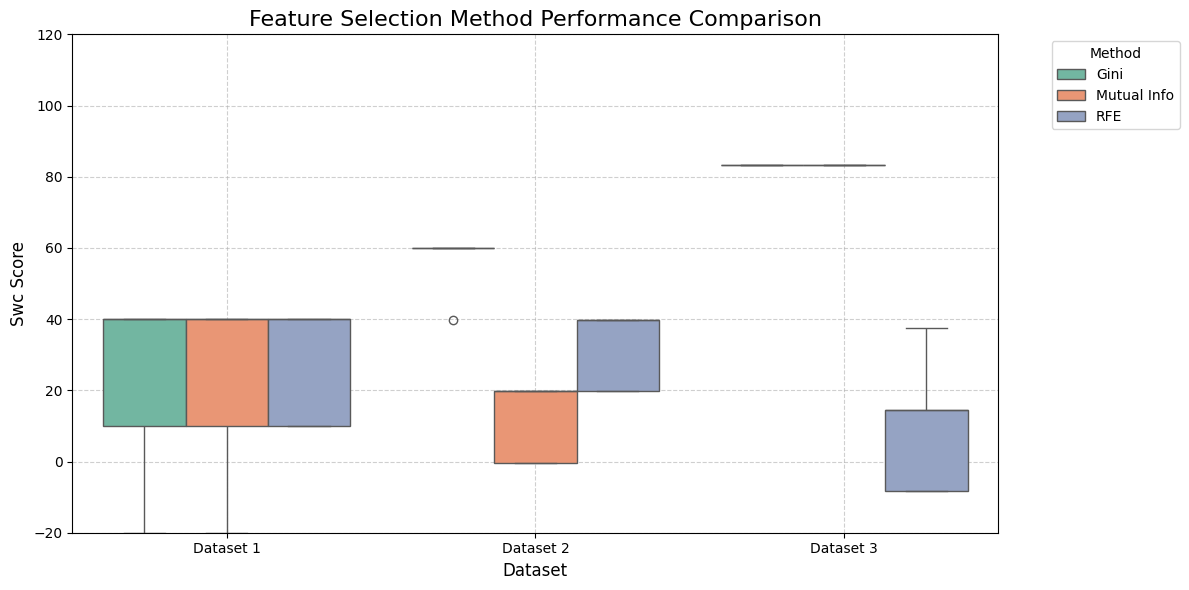

In [10]:
selection_results = evaluate_feature_selection_performance(tests=5)

Testing Gini on Dataset 1...


100%|██████████| 50/50 [00:15<00:00,  3.32it/s]


Testing Mutual Info on Dataset 1...


100%|██████████| 50/50 [00:18<00:00,  2.70it/s]


Testing RFE on Dataset 1...


100%|██████████| 50/50 [00:18<00:00,  2.70it/s]


Testing Gini on Dataset 2...


100%|██████████| 50/50 [00:08<00:00,  6.23it/s]


Testing Mutual Info on Dataset 2...


100%|██████████| 50/50 [00:08<00:00,  6.04it/s]


Testing RFE on Dataset 2...


100%|██████████| 50/50 [00:07<00:00,  6.57it/s]


Testing Gini on Dataset 3...


100%|██████████| 50/50 [00:16<00:00,  2.97it/s]


Testing Mutual Info on Dataset 3...


100%|██████████| 50/50 [00:19<00:00,  2.51it/s]


Testing RFE on Dataset 3...


100%|██████████| 50/50 [00:19<00:00,  2.50it/s]


<Figure size 1500x1000 with 0 Axes>

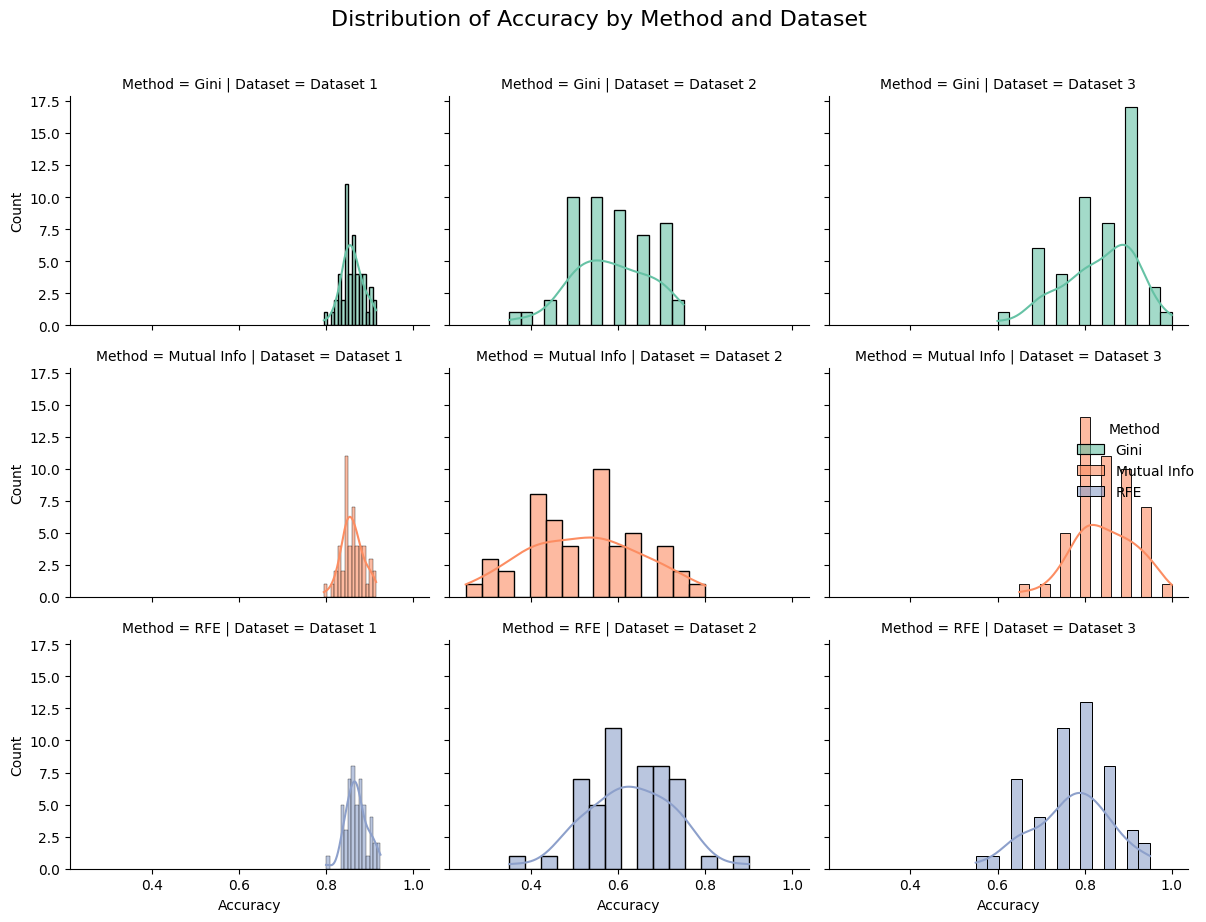

<Figure size 1500x1000 with 0 Axes>

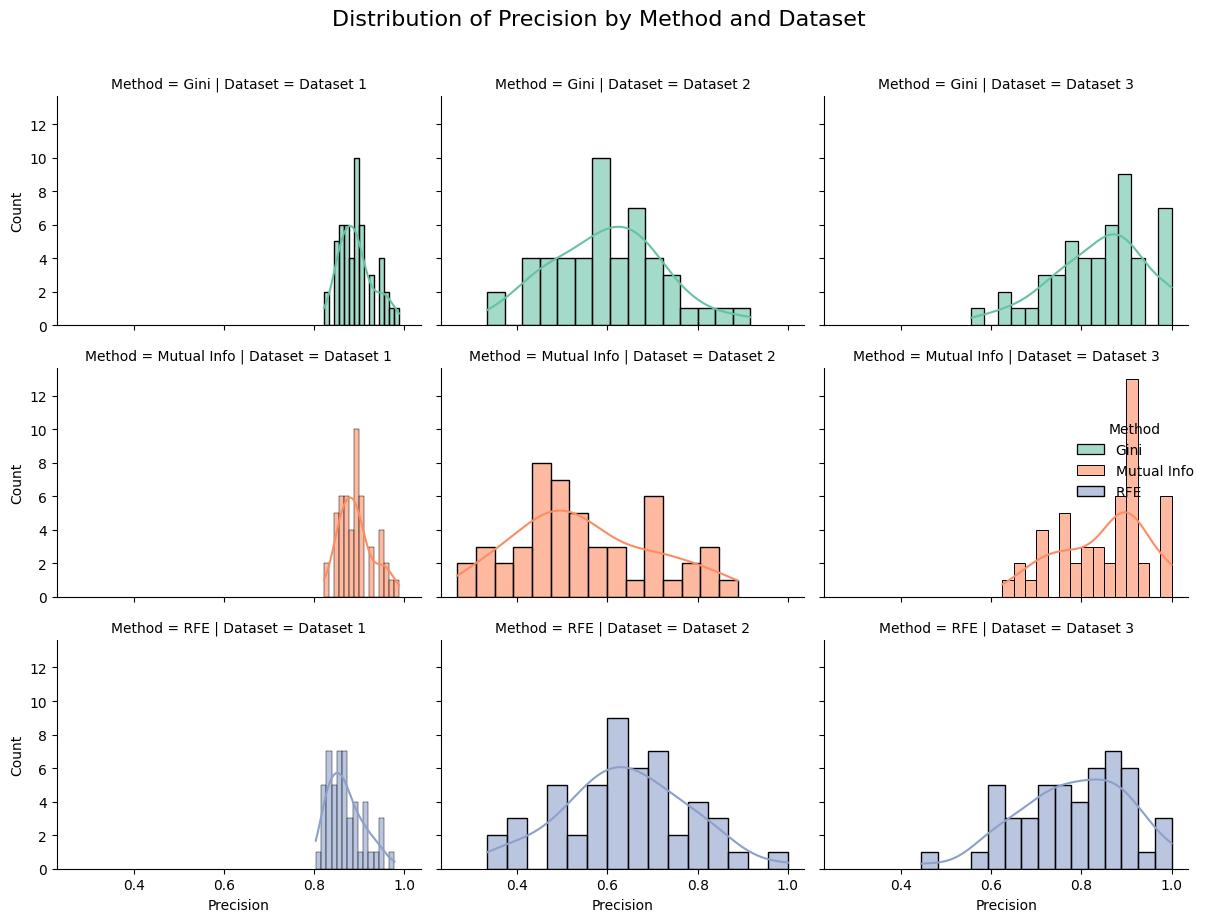

<Figure size 1500x1000 with 0 Axes>

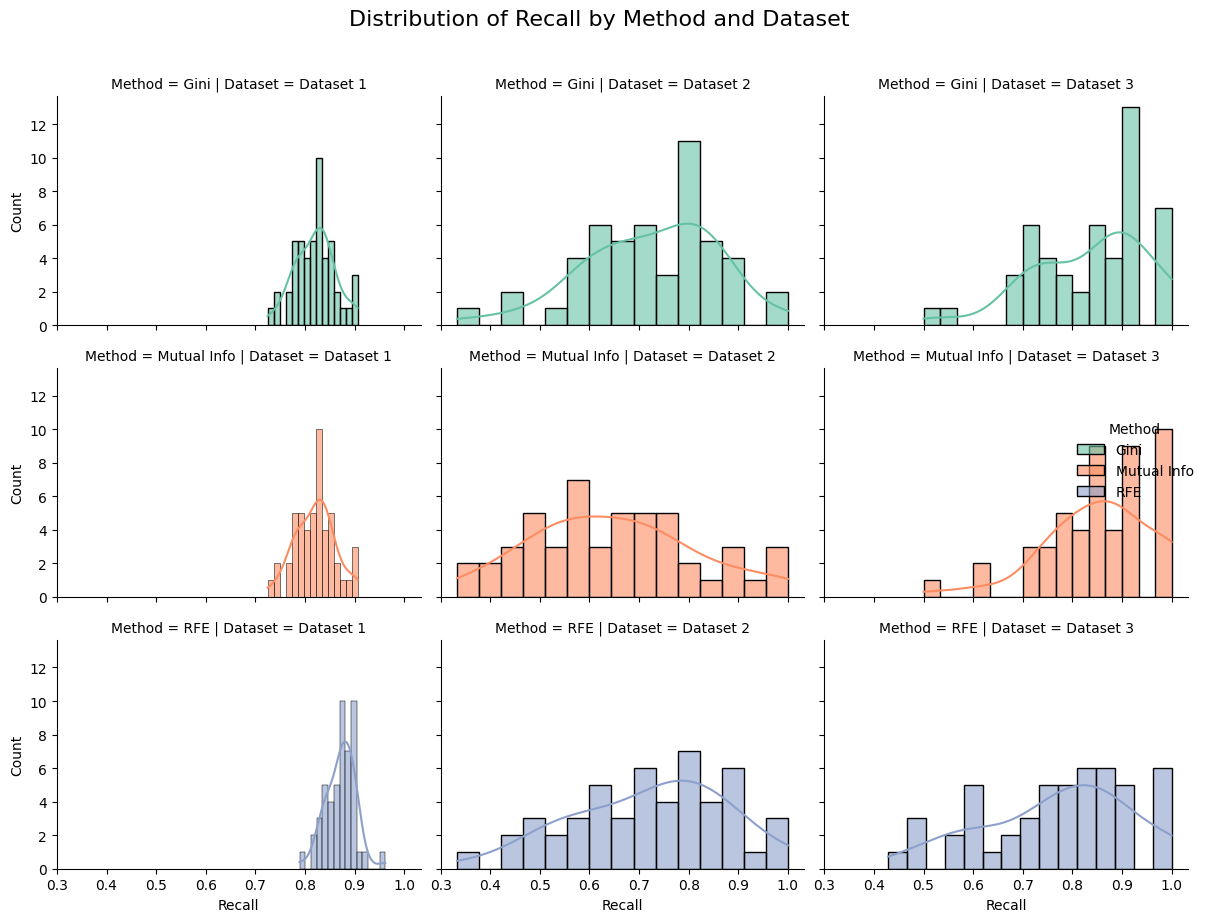

<Figure size 1500x1000 with 0 Axes>

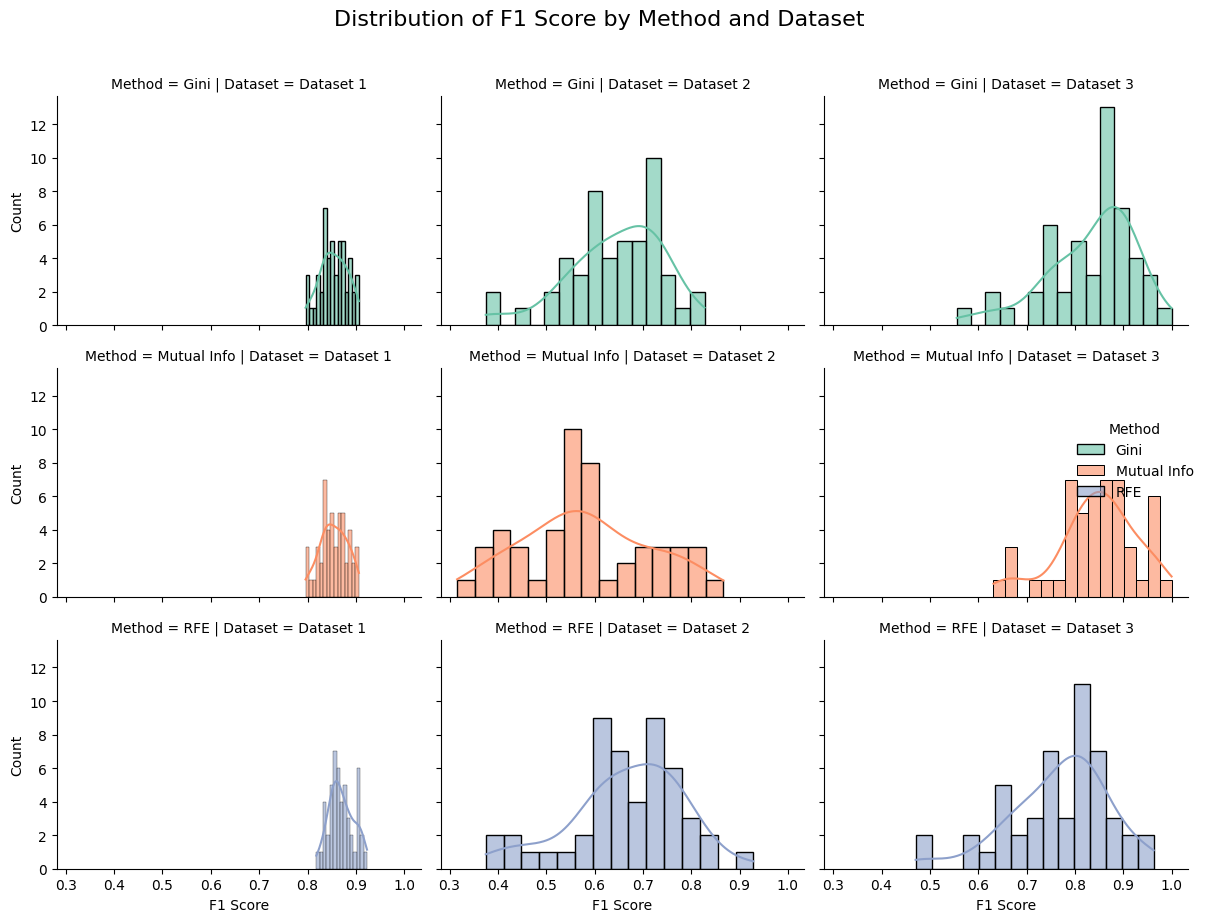

In [14]:
model = RandomForestClassifier(random_state=42)
datasets = {
    'Dataset 1': {
        'generator': dataset_1,
        'relevant_features': [0, 1, 2, 3, 4]
    },
    'Dataset 2': {
        'generator': dataset_2,
        'relevant_features': [0, 1, 2, 3, 4]
    },
    'Dataset 3': {
        'generator': dataset_3,
        'relevant_features': list(range(6))
    }
}

feature_selectors = {
    'Gini': gini_method,
    'Mutual Info': mutual_info_method,
    'RFE': rfe
}
performance_results = evaluate_model_performance(model, datasets, feature_selectors)

# Dimensionality Reduction

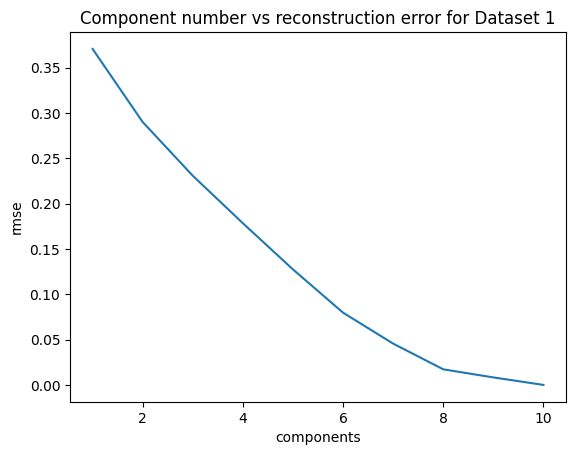

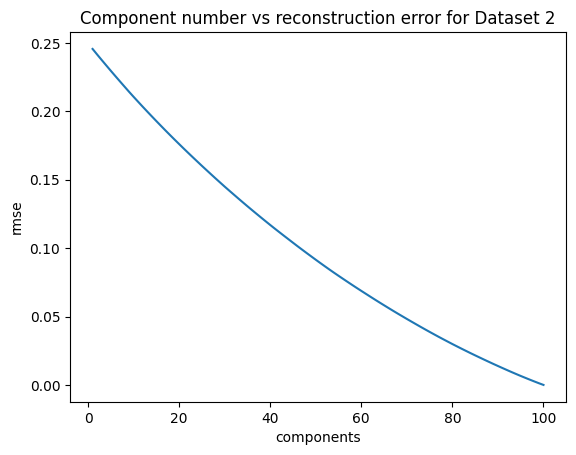

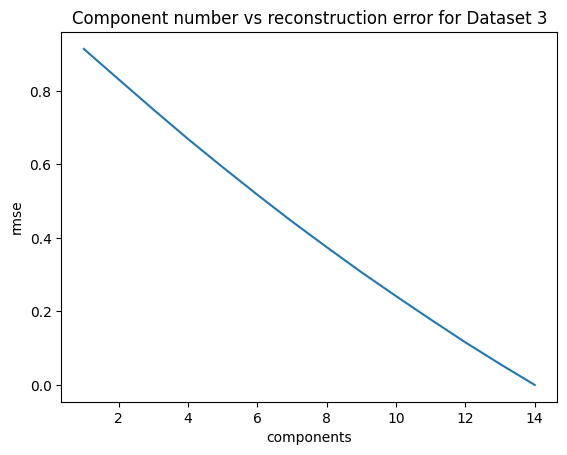

In [24]:
from sklearn.decomposition import PCA
for dataset_method, name in [
    (dataset_1, 'Dataset 1'), 
    (dataset_2, 'Dataset 2'), 
    (dataset_3, 'Dataset 3')]:
    X, y = dataset_method()
    data = []
    for i in range(X.shape[1]):
        pca = PCA(n_components=i+1)
        X_reduced = pca.fit_transform(X)
        X_reconctrucred = pca.inverse_transform(X_reduced)
        rmse = np.mean((X - X_reconctrucred)**2)
        data.append({'components': i+1, 'rmse': rmse})
    data = pd.DataFrame(data)
    sns.lineplot(data, x='components', y='rmse')
    plt.title(f'Component number vs reconstruction error for {name}')
    plt.show()

In [ ]:
def eval_dim_reduction_impact(model, X, y, feature_mask, relevant_mask, n_components=2, random_state=42):
    
    def get_metrics(model, x_train, x_test, y_train, y_test):
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        return {
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1 Score': f1_score(y_test, y_pred)
        }
    
    reducers = {
        'PCA': PCA(n_components=n_components, random_state=random_state),
        'MDS': MDS(n_components=n_components, random_state=random_state),
        't-SNE': TSNE(n_components=n_components, random_state=random_state)
    }
    
    kf = KFold(n_splits=5)
    results = []
    
    for train_index, test_index in tqdm(kf.split(X)):
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        metrics_full = get_metrics(model, x_train, x_test, y_train, y_test)
        metrics_full['Feature Set'] = 'Full Features'
        
        metrics_chosen = get_metrics(model, x_train[:, feature_mask], x_test[:, feature_mask], y_train, y_test)
        metrics_chosen['Feature Set'] = 'Selected Features'
        
        metrics_relevant = get_metrics(model, x_train[:, relevant_mask], x_test[:, relevant_mask], y_train, y_test)
        metrics_relevant['Feature Set'] = 'Relevant Features'
        
        results.extend([metrics_full, metrics_chosen, metrics_relevant])
        
        for name, reducer in reducers.items():
            try:
                x_train_proj = reducer.fit_transform(x_train)
                x_test_proj = reducer.transform(x_test) if hasattr(reducer, 'transform') else reducer.fit_transform(x_test)
                
                metrics_proj = get_metrics(model, x_train_proj, x_test_proj, y_train, y_test)
                metrics_proj['Feature Set'] = f'{name} Projection'
                results.append(metrics_proj)
            except Exception as e:
                print(f"Error with {name}: {e}")
    
    results_df = pd.DataFrame(results)
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=results_df, x='Feature Set', y='F1 Score', palette='viridis')
    plt.title('F1-Score Comparison Across Feature Sets and Dimensionality Reduction Techniques', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
    
    return results_df

Error with t-SNE: 'n_components' should be inferior to 4 for the barnes_hut algorithm as it relies on quad-tree or oct-tree.
Error with t-SNE: 'n_components' should be inferior to 4 for the barnes_hut algorithm as it relies on quad-tree or oct-tree.
Error with t-SNE: 'n_components' should be inferior to 4 for the barnes_hut algorithm as it relies on quad-tree or oct-tree.
Error with t-SNE: 'n_components' should be inferior to 4 for the barnes_hut algorithm as it relies on quad-tree or oct-tree.
Error with t-SNE: 'n_components' should be inferior to 4 for the barnes_hut algorithm as it relies on quad-tree or oct-tree.


/tmp/ipykernel_30784/1723338419.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=results_df, x='Feature Set', y='F1 Score', palette='viridis')


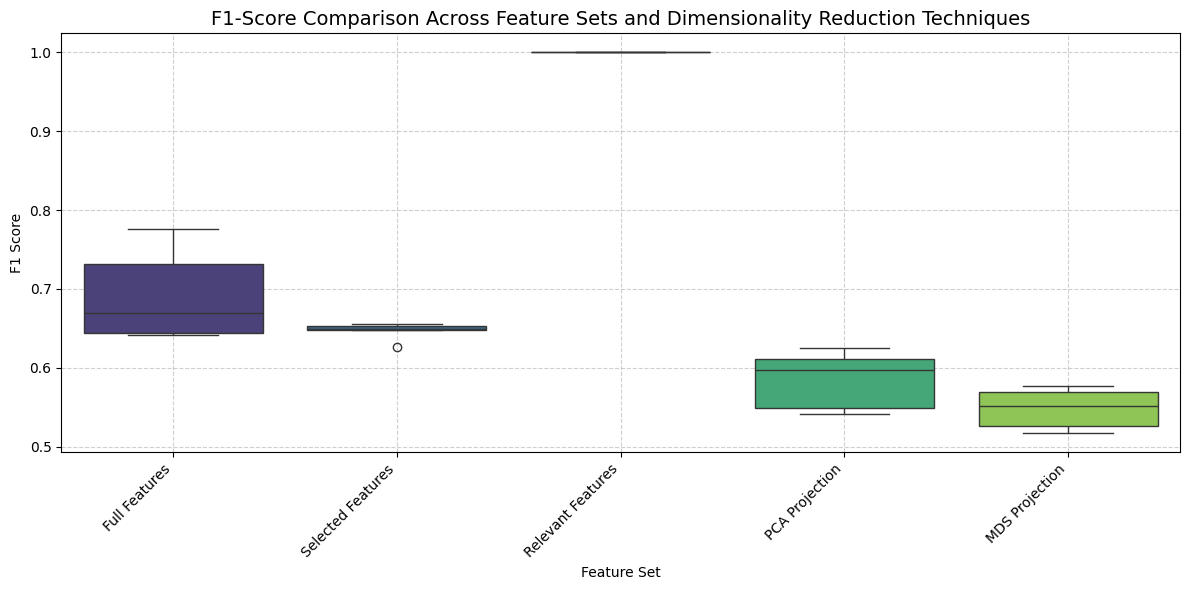

,Accuracy,Precision,Recall,F1 Score,Feature Set
0,0.570,0.578947,0.719626,0.641667,Full Features
1,0.605,0.618644,0.682243,0.648889,Selected Features
2,1.000,1.000000,1.000000,1.000000,Relevant Features
3,0.475,0.508197,0.579439,0.541485,PCA Projection
4,0.440,0.480620,0.579439,0.525424,MDS Projection
5,0.610,0.612403,0.738318,0.669492,Full Features
6,0.605,0.614754,0.700935,0.655022,Selected Features
7,1.000,1.000000,1.000000,1.000000,Relevant Features
8,0.490,0.521008,0.579439,0.548673,PCA Projection
9,0.530,0.558559,0.579439,0.568807,MDS Projection


In [17]:
model = RandomForestClassifier(random_state=42)
X, y = dataset_2()
chosen_features = gini_method(X, y, 5)
eval_dim_reduction_impact(model, X, y, chosen_features, [0, 1, 2, 3, 4], n_components=5)